<b>Here is the problem statement: </b>

</n>
You work as a data scientist with a small team of data scientists for a cargo shipping company based in Finland. </r>
90% of goods are imported into Finland via cargo shipping. You are tasked with saving 20% of the costs for cargo
operations at the port of Turku, Finland. This can be achieved by developing an ML solution that predicts weather 
conditions at the port 4 hours in advance. You need to monitor for possible rainy conditions, which can distort operations
at the port with human resources and transportation, which in turn affects supply chain operations at the port. 
Your ML solution will help port authorities to predict possible rain 4 hours in advance; this will save 20% of costs and
enable smooth supply chain operations at the port.

In [1]:
# couldn't register with my Verve card, so cannot use Azure
# import Libraries
from azureml.core import Workspace, Dataset
from azureml.core.run import Run
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.model import Model
from azureml.core.authentication import ServicePrincipalAuthentication
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow, pickle


In [6]:

# import the data
df = pd.read_csv('weather_dataset_raw.csv')


In [7]:
# overview of the data stats
df.describe()

,Start Time,Duration,Run ID,Name,Source Type,Source Name,User,Status
count,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
'''
The data types are mostly FLOAT & INT as expected. 
The TIMESTAMP column should be DateTime instead of object
'''
df.dtypes

Start Time     object
Duration       object
Run ID         object
Name           object
Source Type    object
Source Name    object
User           object
Status         object
dtype: object

In [ ]:

# convert the TIMESTAMP column to Datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# to check for missing data
# df.isnull().values.any()

# NaN values were only observed in the Weather_conditions column
df['Weather_conditions'].fillna(method='ffill', inplace=True, axis=0)


Label Encoding

In [7]:

# check the different values found in Weather_conditions
df['Weather_conditions'].value_counts()


rain     82271
snow     10712
clear     3470
Name: Weather_conditions, dtype: int64

In [9]:

# convert SNOW & CLEAR to No_rain
df['Weather_conditions'].replace({'snow': 'no_rain', 'clear': 'no_rain'}, inplace=True)

le = LabelEncoder()
y = df['Weather_conditions']
y = le.fit_transform(y)


# add the new column to the DataFrame
y = pd.DataFrame(data=y, columns=['Weather_condition'])
df = pd.concat([df, y], axis=1)
df.drop(['Weather_conditions'], axis=1, inplace=True)
df.head()


,S_No,Timestamp,Location,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Weather_condition
0,0,2006-04-01 00:00:00+02:00,"Port of Turku, Finland",9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,1
1,1,2006-04-01 01:00:00+02:00,"Port of Turku, Finland",9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,1
2,2,2006-04-01 02:00:00+02:00,"Port of Turku, Finland",9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,1
3,3,2006-04-01 03:00:00+02:00,"Port of Turku, Finland",8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,1
4,4,2006-04-01 04:00:00+02:00,"Port of Turku, Finland",8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,1


In [11]:

# task is to forecast weather condition 4hrs ahead, so we shift by 4 and create *Future_weather_conditions
df['Future_weather_conditions'] = df.Weather_condition.shift(4, axis=0)
# drop the NULL values created from the Shifting
df.dropna(inplace=True)


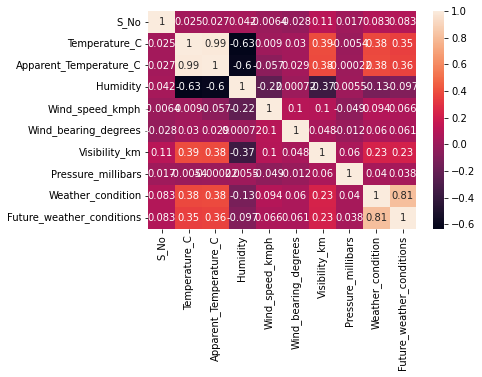

In [12]:

# check the correlation between values
df.corr(method='pearson')
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()


In [17]:

# Serial_No & Apparent Temperature columns are dropped
# Apparent_Temp_C 
df.drop(columns=['S_No', 'Apparent_Temperature_C'], inplace=True)

Time series analysis of temperature over time

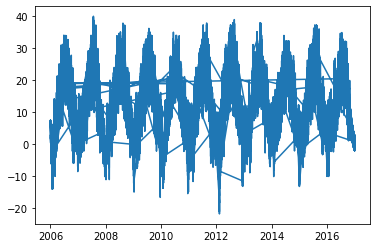

In [20]:

time = df['Timestamp']
temp = df['Temperature_C']

# plot the graph
plt.plot(time, temp)
plt.show()


Data registration and versioning

In [ ]:

# register & version the preprocessed data to ML workspace using the Azure ML SDk
subscription_id = '---insert your subscription ID here----'
resource_group = 'Learn_MLOps'
workspace_name = 'MLOps_WS'
workspace = Workspace(subscription_id, resource_group, workspace_name)

# get the default datastore linked to upload prepared data
datastore = workspace.get_default_datastore()
#upload the local file from src_dir to target_path in datastore
datastore.upload(src_dir=r'/Downloads', target_path='data')
dataset = Dataset.Tablular.from_delimited_files(datastore.path('weather_dataset_processed.csv'))


In [ ]:

# preview the first 3 rows from the datastore
dataset.take(3).to_pandas_dataframe()

In [ ]:

# when the data is uploaded to the datastore, then we will register the dataset to the workspace
weather_ds = dataset.register(workspace=workspace, name='weather_ds_portofTurku', description='processed weatherdata')

In [ ]:
# set the tracking URI
uri = workspace.get_mlflow_tracking_uri(workspace)
mlflow.set_tracking_uri(uri)

# import the Preprocessed data
dataset = Dataset.get_by_name (workspace, name='processed_weather_data_portofTurku')

# after retrieving the dataset, split into training & testing
df_training = df.iloc[:77160]
df_test = df.drop(df_training.index)
df_training.to_csv('Data/training_data.csv',index=False)
df_test.to_csv('Data/test_data.csv',index=False)

# after spitting the Dataset, the 2 datasets are registered to the Datastore (ML workspace)
datastore = workspace.get_default_datastore()
datastore.upload(src_dir='Data', target_path='data')
training_dataset = Dataset.Tabular.from_delimited_files(datastore.path('data/training_data.csv'))

validation_dataset = Dataset.Tabular.from_delimited_files(datastore.path('data/validation_data.csv'))
training_ds = training_dataset.register(workspace=workspace, name='training_dataset', description='Dataset to use for ML training')
test_ds = validation_dataset.register(workspace=workspace, name='test_dataset', description='Dataset for validation ML models')

In [ ]:

# to ingest Data into ML pipeline, import it using the **get_name()**, then
# convert to pandas dataframe using **to_pandas_dataframe()**
dataset = Dataset.get_by_name (workspace, name='training_dataset')
df = dataset.to_pandas_dataframe ( )

In [ ]:

# before training the ML models, select the right features and scale the data
X = df[['Temperature_C', 'Humidity', 'Wind_speed_kmph', 'Wind_bearing_degrees', 'Visibility_km', 'Pressure_millibars', 'Current_weather_condition']].values
y = df['Future_weather_condition'].values

# split the training dataset into training & testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# scale the dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)


Train the model using SVM

In [ ]:

# begin the ML training by initiating the training using **Experiment()** function from the Azure SDK
# this function logs & monitors the ML training performance in the Azure workspace
myexperiment = Experiment(workspace, "support-vectormachine")

# initiate the MLflow experiment to observe a different perspective
mlflow.set_experiment("mlflow-support-vector-machine")

In [ ]:

# next is hyperparameter tuning to find best parameters
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC( )
# initialize a run in Azureml and mlflow experiments
run = myexperiment.start_logging()
mlflow.start_run()
run.log("dataset name", dataset.name)
run.log("dataset Version", dataset.version)
svc_grid = GridSearchCV(svc, parameters)
svc_grid.fit(X_train, y_train)


In [ ]:

# finally, using the best model, a new model is trained
svc = SVC(C=svc_grid.get_params(deep=True)['estimator__C'], kernel=svc_grid.get_params(deep=True)['estimator__kernel'])
svc.fit(X_train, y_train)
# Logging training parameters to AzureML and MLFlow experiments
run.log("C", svc_grid.get_params(deep=True)['estimator__C'])
run.log("Kernel", svc_grid.get_params(deep=True)['estimator__kernel'])

# this outputs the SVC model with seom parameters which shows the model has been trained

Train the Random Forest classifier model

In [ ]:

myexperiment = Experiment(workspace, "support-vectormachine")
mlflow.set_experiment("mlflow-support-vector-machine")

rf = RandomForestClassifier (max_depth=10, random_state=0, n_estimators=100)

# initialize runs in Azureml and mlflow
run = myexperiment.start_logging()
mlflow.start_run()
# Log dataset used
run.log("dataset name", dataset.name)
run.log("dataset Version", dataset.version)
rf.fit(X_train, y_train)
# Logging training parameters to AzureML and MLFlow experiments
run.log("max_depth", 10)
run.log("random_state", 0)
run.log("n_estimators", 100)


In [ ]:

# test the SVM classifier, X_test & y_test were not actually initialized.
predicted_svc = svc.predict(X_test)
acc = accuracy_score(y_test, predicted_svc)
fscore = f1_score(y_test, predicted_svc, average="macro")
precision = precision_score(y_test, predicted_svc, average="macro")

recall = recall_score(y_test, predicted_svc, average="macro")
run.log("Test_accuracy", acc)
run.log("Precision", precision)
run.log("Recall", recall)
run.log("F-Score", fscore)


Register models & production artifacts

In [ ]:

# register model on AzureML workspace

# register SVC
model = Model.register (model_path = './outputs/svc.onnx', model_name = "support-vectorclassifier",
                tags = {'dataset': dataset.name, 'version': dataset.version, 'hyparameter-C': '1', 'testdataaccuracy': '0.9519'}, 
                model_framework='pandas==0.23.4',   description = "Support vector classifier to predict weather at port of Turku", 
                workspace = workspace)

# register Random forest
model = Model.register (model_path = './outputs/rf.onnx', model_name = "random-forest-classifier", 
                tags = {'dataset': dataset.name, 'version': dataset.version, 'hyparameter-C': '1', 'testdataaccuracy': '0.9548'},
                model_framework='pandas==0.23.4', description = "Random forest classifier to predict weather at port of Turku", workspace = workspace)



